In [70]:
import cv2
import random
import time
import numpy as np
from scipy import misc

from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline
plt.style.use('ggplot')
import os
import sys
sys.path.append('../common/')
import utils

# 开始
## 首先读入所有图片

In [71]:
import pickle

## (IM_train,y_train,IM_test)三个矩阵的形状如下：
### IM_train:  58512个 (100 * 100 * 3 )的矩阵
### y_train:  58512个实数，代代表图片标签，0代表非人脸，1代表人脸
### IM_test:  200个( 250 * 250 * 3) 的矩阵

In [72]:
import pickle
with open('./xy.pkl','rb') as whdl:
    (IM_train,y_train,IM_test) = pickle.load(whdl)

# 看一些训练集中的图片，图片上的数字为图片的label

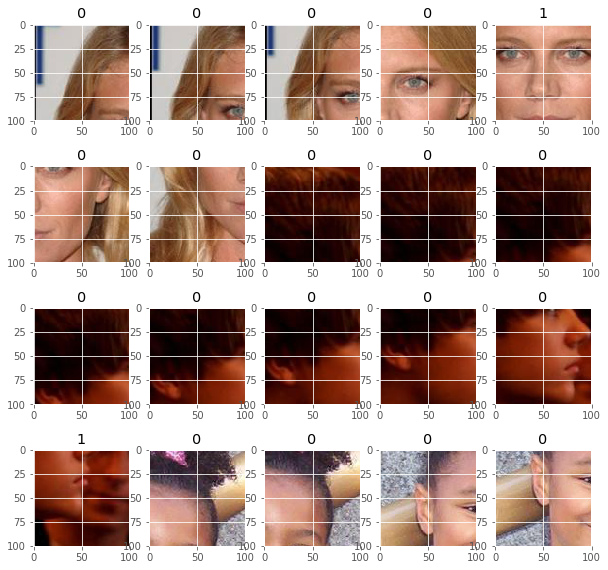

In [76]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i + 1)
    plt.imshow(IM_train[i * 10 ])
    plt.title(y_train[i * 10])

# 分别查看一张图片中的三个色道

In [78]:
img_demo = IM_train[0]

In [80]:
img_demo[:,:,0].shape

(100, 100)

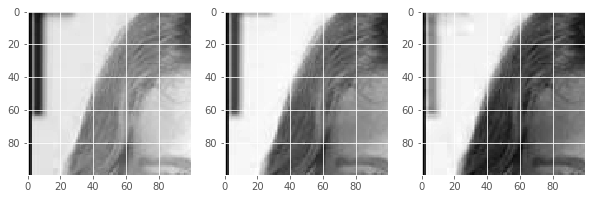

In [83]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i + 1)
    plt.imshow(img_demo[:,:,i],cmap='gray')

# 使用直方图统计某一张训练图片的颜色分布

In [84]:
import pandas as pd

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47e9a6ef28>]], dtype=object)

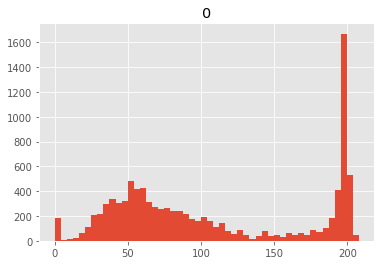

In [100]:
pd.DataFrame(img_demo[:,:,2].reshape(-1)).hist(bins=50)#(0~255) blue green red

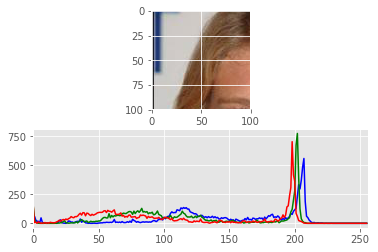

In [94]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[0])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[0]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

# 使用更少的bins生成颜色直方图

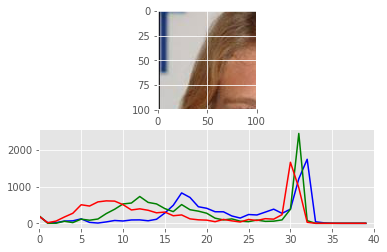

In [106]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[0])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[0]],[i],None,[40],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,40])
plt.show()

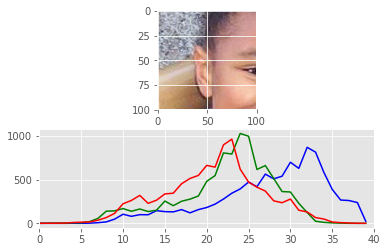

In [109]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[180])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[180]],[i],None,[40],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,40])
plt.show()

# 生成 feature


In [110]:

pb = utils.ProgressBar(worksum=len(IM_train))
pb.startjob()
features = []
targets = []
for one_image,one_target in zip(IM_train,y_train):
    one_feature = []
    if len(one_image.shape) != 3:
        continue
    for i,col in enumerate(color):
        histr = cv2.calcHist([one_image],[i],None,[40],[0,256]).T[0]
        one_feature.append(histr)
    one_feature = np.concatenate(one_feature) # (120)
    features.append(one_feature)
    targets.append(one_target)
    pb.complete(1)

 99.76 % [=================================================>-] 58371/58512 	 used:9s eta:0 s

In [ ]:
(40) (40) (40) -> (120)

# 经过提取之后的feature 的形状大小和feature可视化

In [111]:
features[0].shape

(120,)

In [112]:
len(features)

58371

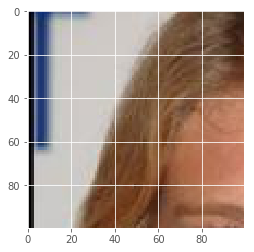

In [114]:
plt.imshow(IM_train[0])

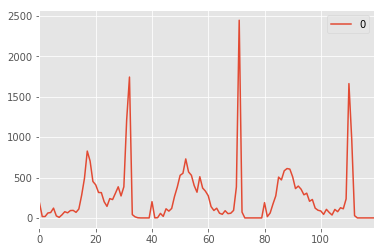

In [113]:
pd.DataFrame(features[0]).plot()

In [115]:
features[0].shape

(120,)

# 查看标签的分布

In [116]:
from collections import Counter
Counter(targets)

Counter({0: 55620, 1: 2751})

In [117]:
len(features),len(targets)

(58371, 58371)

In [119]:
train_x,val_x = features[:-10000], features[-10000:]
train_y,val_y = targets[:-10000], targets[-10000:]

In [120]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [121]:
lr = LogisticRegression()

In [122]:
lr_model = lr.fit(train_x,train_y)

In [123]:
val_pred = lr_model.predict_proba(val_x)[:,1]

In [124]:
val_pred

array([ 0.00125628,  0.00459967,  0.0254959 , ...,  0.04332959,
        0.09291954,  0.13279359])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47be6cd470>]], dtype=object)

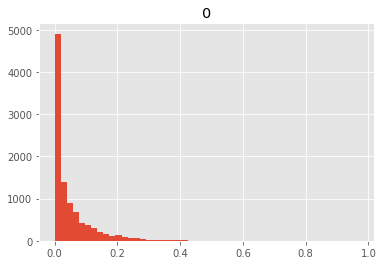

In [125]:
pd.DataFrame(val_pred).hist(bins=50)

In [126]:
from sklearn import metrics

In [127]:
 fpr, tpr, thresholds = metrics.roc_curve(val_y, val_pred, pos_label = 1)

In [128]:
metrics.auc(fpr, tpr)

0.80144708349877214

In [129]:
def get_feature(input_img):
    one_feature = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([input_img],[i],None,[40],[0,256]).T[0]
        one_feature.append(histr)
    one_feature = np.concatenate(one_feature)

    return one_feature

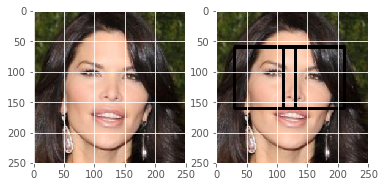

In [131]:

sample_image = np.copy(IM_test[2])
plt.subplot(1,2,1)
plt.imshow(sample_image)
for i in range(0,250 - 100,10):
    for j in range(0,250 - 100,10):
        one_feature = get_feature(sample_image[i:i + 100,j:j + 100])
        result = lr_model.predict_proba([one_feature])
        #print(result)
        if result[0][1] > 0.1:
            cv2.rectangle(sample_image,(i,j),(i + 100,j + 100),(0,0,0),3)
plt.subplot(1,2,2)
plt.imshow(sample_image)

# pickle 使用

In [132]:
import pickle

In [133]:
a = np.asarray([1,2,3])

In [138]:
?pickle.dump

In [142]:
?pickle.load